In [1]:
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('./modules') and not os.path.exists('modules.zip'):
    from google.colab import files
    uploaded = files.upload()
if not os.path.exists('./modules') and os.path.exists('modules.zip'):
    os.system('unzip modules.zip -d .')

!pip3 install optuna
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import optuna
from modules import EEGDataset
from modules.utils import split_and_get_loaders, evaluate_model, manual_write_study_params
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Saving modules.zip to modules.zip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.8 MB/s eta 0:00:00


device(type='cuda')

In [2]:
#! need to modify those for the competition itself
TRIAL_LENGTH = 640  # frequency of changing.. frequency
# Download dataset
path_1 = kagglehub.dataset_download("girgismicheal/steadystate-visual-evoked-potential-signals")
path_1 += "/SSVEP (BrainWheel)"
print("Download datasetaset files:", "\n", path_1)

100%|██████████| 23.3M/23.3M [00:00<00:00, 153MB/s]

Extracting files...


Download datasetaset files: 
 /root/.cache/kagglehub/datasets/girgismicheal/steadystate-visual-evoked-potential-signals/versions/1/SSVEP (BrainWheel)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class DepthWiseConv2D(nn.Module):
    def __init__(self, in_channels, kernel_size, dim_mult=1, padding=0, bias=False):
        super(DepthWiseConv2D, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels * dim_mult, padding=padding, kernel_size=kernel_size, groups=in_channels, bias=bias)

    def forward(self, x: torch.Tensor):
        return self.depthwise(x)


class SeperableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeperableConv2D, self).__init__()
        self.depthwise = DepthWiseConv2D(in_channels, kernel_size, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class SSVEPClassifier(nn.Module):
    # EEG Net Based
    # todo look at this https://paperswithcode.com/paper/a-transformer-based-deep-neural-network-model
    def __init__(self, n_electrodes=16, n_samples=128, out_dim=4, dropout=0.25, kernLength=256, F1=96, D=1, F2=96, hidden_dim=100, layer_dim=1):
        super().__init__()

        # B x C x T
        self.block_1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False),
            nn.BatchNorm2d(F1),
            #
            DepthWiseConv2D(F1, (n_electrodes, 1), dim_mult=D, bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.MaxPool2d((1, 2)), # todo try making this max pool
            nn.Dropout(dropout),
            #
            SeperableConv2D(F1 * D, F2, kernel_size=(1, 16), padding='same', bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(dropout),
        )

        self.lstm_head = LSTMModel(F2, hidden_dim, layer_dim, out_dim)

    def forward(self, x: torch.Tensor):
        """expected input shape: BxCxT"""
        x = x.unsqueeze(1)
        y = self.block_1(x) # B x F1 x 1 x time_sub

        y = y.squeeze(2) # B x F1 x time_sub
        y = y.permute(0, 2, 1) # B x time_sub x F1
        y = self.lstm_head(y)

        return y


dummy_x = torch.randn(5, 14, 320)
model = SSVEPClassifier(n_electrodes=dummy_x.shape[1], n_samples=dummy_x.shape[2])
model(dummy_x)

tensor([[-0.0195,  0.3192, -0.1630,  0.1811],
        [-0.0165,  0.3870, -0.1583,  0.0998],
        [-0.0478,  0.3266, -0.1169,  0.0824],
        [ 0.0051,  0.3093, -0.0847,  0.1376],
        [-0.0976,  0.3636, -0.1377,  0.0726]], grad_fn=<AddmmBackward0>)

In [9]:
window_length = 320
stride = window_length // 2
batch_size = 32

dataset = EEGDataset(path_1, TRIAL_LENGTH, window_length, stride=stride)
train_loader, val_loader, test_loader = split_and_get_loaders(dataset, batch_size)


In [10]:
model = SSVEPClassifier(n_electrodes=dummy_x.shape[1], n_samples=dummy_x.shape[2]).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
avg_losses = []
val_accuracies = []

epochs = 200
for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x).to(device)

        loss = criterion(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader)
    avg_losses.append(avg_loss)

    evaluation = evaluate_model(model, val_loader, device)
    val_accuracies.append(evaluation)
    print(f'epoch: {epoch}, avg_loss: {avg_loss}, val_evaluation: {evaluation}')

epoch: 0, avg_loss: 1.3928805647826776, val_evaluation: 0.26875
epoch: 1, avg_loss: 1.368941687956089, val_evaluation: 0.30625
epoch: 2, avg_loss: 1.342956211508774, val_evaluation: 0.3625
epoch: 3, avg_loss: 1.329485009356243, val_evaluation: 0.34375
epoch: 4, avg_loss: 1.3120341417266101, val_evaluation: 0.3375
epoch: 5, avg_loss: 1.304872230785649, val_evaluation: 0.334375
epoch: 6, avg_loss: 1.2907797447065028, val_evaluation: 0.3625
epoch: 7, avg_loss: 1.2516086421361783, val_evaluation: 0.359375
epoch: 8, avg_loss: 1.2355819271831978, val_evaluation: 0.365625
epoch: 9, avg_loss: 1.218538926868904, val_evaluation: 0.38125
epoch: 10, avg_loss: 1.193409652244754, val_evaluation: 0.396875
epoch: 11, avg_loss: 1.1423812232366422, val_evaluation: 0.38125
epoch: 12, avg_loss: 1.1423980695445364, val_evaluation: 0.35625
epoch: 13, avg_loss: 1.136247142059047, val_evaluation: 0.375
epoch: 14, avg_loss: 1.0839109929596507, val_evaluation: 0.4
epoch: 15, avg_loss: 1.0308051778049003, val_ev

KeyboardInterrupt: 

min avg_losses: 2.594960134468615e-05
max val_accuracies: 0.490625


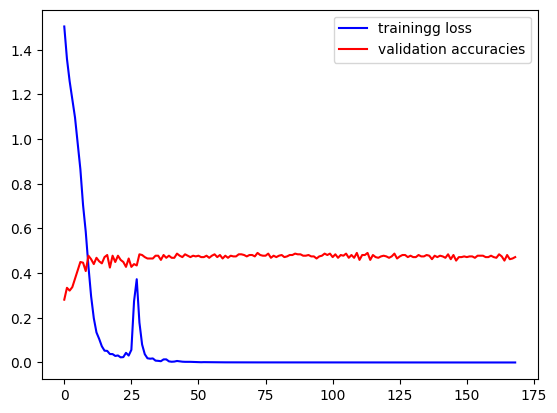

In [ ]:
# maxpool
plt.plot(range(len(avg_losses)), avg_losses, "b-", label="trainingg loss")
plt.plot(range(len(val_accuracies)), val_accuracies, "r-", label="validation accuracies")
plt.legend()
print(f"min avg_losses: {min(avg_losses)}")
print(f"max val_accuracies: {max(val_accuracies)}")

In [10]:
class Trainer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_epochs = 1000
        self.tune_epochs = 50
        self.optuna_n_trials = 120

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.trial = None

        self.train_loader = None
        self.eval_loader = None
        self.test_loader = None
        self.dataset = None

        self.storage = "sqlite:///optuna_studies.db"
        self.study_name = "ssvep_classifier_optimization"

        self.checkpoint_path = "./checkpoints/ssvep"
        os.makedirs(os.path.join(self.checkpoint_path, "models"), exist_ok=True)
        self.checkpoint_model_path = os.path.join(self.checkpoint_path, "models")

    def _train_loop(self, n_epochs: int, should_save=False, should_print=False):
        assert isinstance(self.optimizer, torch.optim.Optimizer), "optimizer is not a valid optimizer"
        assert isinstance(self.train_loader, DataLoader), "train_laoder is not valid Datloader"
        if self.trial is None:
            print("Warning: self.trial is none, we are probably in acutal training phase")

        for epoch in range(n_epochs):
            self.model.to(self.device)
            self.model.train()

            avg_loss = 0
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.model(x)  # B x out_size
                loss = self.criterion(y_pred, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()

            avg_loss = avg_loss / len(self.train_loader)
            evaluation = evaluate_model(self.model, self.val_loader, self.device)

            if self.trial is not None:
                self.trial.report(evaluation, epoch)
                if self.trial.should_prune():
                    optuna.exceptions.TrialPruned()

            if should_print:
                print(f"epoch {epoch}, evaluation {evaluation}, avg_loss {avg_loss}")

            if should_save:
                self.model.cpu()
                torch.save(self.model.state_dict(), os.path.join(self.checkpoint_model_path, f"ssvep.pth"))
                self.model.to(self.device)


    def _prepare_training(self, is_trial):
        if is_trial:
            assert isinstance(self.trial, optuna.Trial), "trial is none, cant' suggest params"

            # network params
            n_electrodes = self.trial.suggest_categorical("n_electrodes", [16, 32])
            n_samples = self.trial.suggest_categorical("n_samples", [128, 256])
            dropout = self.trial.suggest_float("dropout", 0, 0.5)
            kernLength = self.trial.suggest_categorical("kernLength", [128, 256, 512])
            F1 = self.trial.suggest_categorical("F1", [64, 96, 128])
            D = self.trial.suggest_categorical("D", [1, 2, 3])
            F2 = self.trial.suggest_categorical("F2", [64, 96, 128])
            hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
            layer_dim = self.trial.suggest_categorical("layer_dim", [1, 2, 3, 4])

            # dataset params
            window_length = self.trial.suggest_categorical("window_length", [160, 320])
            stride_factor = self.trial.suggest_int("stride", 1, 3)

            # training params
            lr = self.trial.suggest_float("lr", 3e-4, 3e-2, log=True)
            batch_size = self.trial.suggest_categorical("batch_size", [32, 64])

        else:
            best_params = self._get_study().best_params

            window_length = best_params['window_length']
            stride_factor = best_params['stride']
            dropout = best_params["dropout"]
            lr = best_params["lr"]
            batch_size = best_params["batch_size"]

        stride = int(window_length // stride_factor)
        self.dataset = EEGDataset(path_1, TRIAL_LENGTH, window_length, stride=stride)
        unique_freqs = torch.unique(self.dataset.labels)

        n_samples = self.dataset.data[0].shape[1] # data[x] shape CxT
        n_electrodes = self.dataset.data[0].shape[0]
        out_size = len(unique_freqs)

        self.model = SSVEPClassifier(
            n_electrodes=n_electrodes,
            n_samples=n_samples,
            out_dim=out_size,
            dropout=dropout,
            kernLength=kernLength,
            F1=F1,
            D=D,
            F2=F1,
            hidden_dim=hidden_dim,
            layer_dim=layer_dim
        )
        self.train_loader, self.val_loader, self.test_loader = split_and_get_loaders(self.dataset, batch_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def _objective(self, trial: optuna.Trial):
        self.trial = trial
        self._prepare_training(True)

        self._train_loop(self.tune_epochs, should_save=False, should_print=False)
        evaluation = evaluate_model(self.model, self.val_loader, self.device)
        return evaluation

    def _get_study(self):
        return optuna.create_study(study_name=self.study_name, storage=self.storage, direction="maximize", load_if_exists=True)

    def optimize(self, delete_existing=False):
        if delete_existing:
            try:
                optuna.delete_study(study_name=self.study_name, storage=self.storage)
            except Exception:
                pass

        study = self._get_study()
        study.optimize(self._objective, n_trials=self.optuna_n_trials, timeout=60 * 10)

        # Print optimization results
        print("\nStudy statistics:")
        print(f"  Number of finished trials: {len(study.trials)}")
        print(f"  Number of pruned trials: {len(study.get_trials(states=[optuna.trial.TrialState.PRUNED]))}")
        print(f"  Number of complete trials: {len(study.get_trials(states=[optuna.trial.TrialState.COMPLETE]))}")

        print("\nBest trial:")
        trial = study.best_trial
        print(f"  Value: {trial.value}")
        print("\nBest hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")

        return study.best_params

    def train(self):
        self.trial = None
        self._prepare_training(False)

        self._train_loop(self.train_epochs, should_save=True, should_print=True)
        evaluation = evaluate_model(self.model, self.val_loader, self.device)
        print("done training")
        return evaluation

In [11]:
trainer = Trainer()
delete_existing = False
trainer.optimize(delete_existing)

[I 2025-06-18 03:50:44,409] Using an existing study with name 'ssvep_classifier_optimization' instead of creating a new one.
[I 2025-06-18 03:52:01,424] Trial 4 finished with value: 0.5354166666666667 and parameters: {'n_electrodes': 16, 'n_samples': 256, 'dropout': 0.05482288557273096, 'kernLength': 256, 'F1': 128, 'D': 2, 'F2': 96, 'hidden_dim': 256, 'layer_dim': 1, 'window_length': 320, 'stride': 2, 'lr': 0.0003668474508971489, 'batch_size': 32}. Best is trial 4 with value: 0.5354166666666667.
[I 2025-06-18 03:54:00,387] Trial 5 finished with value: 0.26322115384615385 and parameters: {'n_electrodes': 16, 'n_samples': 128, 'dropout': 0.1891406161326139, 'kernLength': 512, 'F1': 64, 'D': 3, 'F2': 128, 'hidden_dim': 64, 'layer_dim': 4, 'window_length': 160, 'stride': 3, 'lr': 0.0038582065406684105, 'batch_size': 32}. Best is trial 4 with value: 0.5354166666666667.
[I 2025-06-18 03:54:45,438] Trial 6 finished with value: 0.471875 and parameters: {'n_electrodes': 16, 'n_samples': 128, '


Study statistics:
  Number of finished trials: 13
  Number of pruned trials: 0
  Number of complete trials: 12

Best trial:
  Value: 0.65625

Best hyperparameters:
  n_electrodes: 32
  n_samples: 256
  dropout: 0.33066508963955576
  kernLength: 256
  F1: 128
  D: 2
  F2: 96
  hidden_dim: 256
  layer_dim: 3
  window_length: 160
  stride: 3
  lr: 0.00030241790493218325
  batch_size: 64


{'n_electrodes': 32,
 'n_samples': 256,
 'dropout': 0.33066508963955576,
 'kernLength': 256,
 'F1': 128,
 'D': 2,
 'F2': 96,
 'hidden_dim': 256,
 'layer_dim': 3,
 'window_length': 160,
 'stride': 3,
 'lr': 0.00030241790493218325,
 'batch_size': 64}

In [ ]:
# manual_write_study_params(trainer.study_name, trainer.storage)
trainer.train()